# Create by Yujie Zhou

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import csv

In [37]:
colunm_names = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
'''
可调参数
'''

# KNNImputer
n_neighbors = 5

# 数据预处理

In [38]:
train_DataFrame = pd.read_csv(filepath_or_buffer="Data/Titanic/train.csv", 
                    names=["PassengerId", "Survived", "Pclass", "Name", "Sex", "Age", 
                    "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"], skiprows=1)
test_DataFrame = pd.read_csv(filepath_or_buffer="Data/Titanic/test.csv", 
                    names=["PassengerId", "Pclass", "Name", "Sex", "Age", 
                    "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"], skiprows=1)
test_AnswerDataFrame = pd.read_csv(filepath_or_buffer="Data/Titanic/gender_submission.csv",
                    names=["PassengerId", "Survived"], skiprows=1)

print(train_DataFrame)
print(test_DataFrame)
print(test_AnswerDataFrame)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

In [39]:
def EncodeData(x: pd.DataFrame) -> list:
    """
    对特征向量进行编码
    将pandas的DataFrame结构转换为list
    同时去除无关列
    :param x: pandas.DataFrame
    :return: 特征向量
    """
    input_data = [[x["Pclass"][i], x["Sex"][i], x["Age"][i], x["SibSp"][i], x["Parch"][i], x["Fare"][i], x["Embarked"][i]] for i in range(len(x))]
    
    return input_data

class PreEncodeData:
    def __init__(self, x: pd.DataFrame) -> pd.DataFrame:
        """
        对输入数据进行预编码
        :param x: pandas.DataFrame 类型数据，为读取的数据
        :return: pandas.DataFrame 编码后的数据
        """
        for i in range(len(x["Sex"])):
            if x["Sex"][i] == 'male':
                x.loc[i, "Sex"] = 1
            elif x["Sex"][i] == 'female':
                x.loc[i, "Sex"] = 0
        
        for i in range(len(x["Embarked"])):
            if x["Embarked"][i] == 'C':
                x.loc[i, "Embarked"] = 0
            elif x["Embarked"][i] == 'Q':
                x.loc[i, "Embarked"] = 1
            elif x["Embarked"][i] == 'S':
                x.loc[i, "Embarked"] = 2
        x = x.drop(columns=["Name", "Ticket", "Cabin"])
        self.MinMax = MinMaxScalerStrategy(x, "Model/Titanic_MinMax.csv")

    
    def PreEncode(self, x: pd.DataFrame) -> pd.DataFrame:
        """
        对再次输入数据进行预编码
        如将测试集数据进行与训练集相同的编码方式

        :param x: pandas.DataFrame 类型数据，为读取的数据
        :return: pandas.DataFrame 编码后的数据
        """
        for i in range(len(x["Sex"])):
            if x["Sex"][i] == 'male':
                x.loc[i, "Sex"] = 1
            elif x["Sex"][i] == 'female':
                x.loc[i, "Sex"] = 0
        
        for i in range(len(x["Embarked"])):
            if x["Embarked"][i] == 'C':
                x.loc[i, "Embarked"] = 0
            elif x["Embarked"][i] == 'Q':
                x.loc[i, "Embarked"] = 1
            elif x["Embarked"][i] == 'S':
                x.loc[i, "Embarked"] = 2
        x = x.drop(columns=["Name", "Ticket", "Cabin"])
        x = self.MinMax.transform(x)
        return x

def EncodeTrainData(x: pd.DataFrame) -> tuple[list, list]:
    """
    对测试集进行编码处理
    将pandas的DataFrame结构转换为list
    同时去除无关列
    :param x: pandas.DataFrame
    :return: 特征向量，标签向量
    """
    input_data = EncodeData(x)
    label = [x["Survived"][i] for i in range(len(x))]

    return input_data, label

In [40]:
class MinMaxScalerStrategy:
    def __init__(self, data: pd.DataFrame, filepath: str):
        self.data = data
        self.min = {
            "Pclass": data["Pclass"].min(),
            "Sex": data["Sex"].min(),
            "Age": data["Age"].min(),
            "SibSp": data["SibSp"].min(),
            "Parch": data["Parch"].min(),
            "Fare": data["Fare"].min(),
            "Embarked": data["Embarked"].min()
        }
        self.max = {
            "Pclass": data["Pclass"].max(),
            "Sex": data["Sex"].max(),
            "Age": data["Age"].max(),
            "SibSp": data["SibSp"].max(),
            "Parch": data["Parch"].max(),
            "Fare": data["Fare"].max(),
            "Embarked": data["Embarked"].max()
        }
        colunm_names = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
        def inner_transform(data: pd.DataFrame) -> pd.DataFrame:
            for name in colunm_names:
                for i in range(len(data[name])):
                    data.loc[i, name] = (data[name][i] - self.min[name]) / (self.max[name] - self.min[name])
            return data
        self.data = inner_transform(self.data)
        # 存储MinMax相关数据
        save_data = []
        save_data.append(colunm_names)
        max_array = []
        min_array = []
        for name in colunm_names:
            max_array.append(self.max[name])
            min_array.append(self.min[name])
        save_data.append(max_array)
        save_data.append(min_array)
        with open(filepath, "w", newline="", encoding="utf-8") as file:
            writer = csv.writer(file)
            writer.writerows(save_data)


    def transform(self, data: pd.DataFrame) -> pd.DataFrame:
        colunm_names = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
        for name in colunm_names:
            for i in range(len(data[name])):
                data.loc[i, name] = (data[name][i] - self.min[name]) / (self.max[name] - self.min[name])
        return data

## 缺省值处理

In [41]:
imputer = KNNImputer(n_neighbors=n_neighbors, weights="distance", copy=False)

# 训练集编码
EncodeModel = PreEncodeData(train_DataFrame)

print("train_DataFrame:")
train_DataFrame = EncodeModel.PreEncode(train_DataFrame)
print(train_DataFrame)

# 测试集编码
print("test_DataFrame:")
test_DataFrame = EncodeModel.PreEncode(test_DataFrame)
print(test_DataFrame)

# 缺失值填充
print("train_DataFrame_filled:")
train_DataFrame_filled = pd.DataFrame(imputer.fit_transform(train_DataFrame), columns=train_DataFrame.columns)
print(train_DataFrame_filled)

print("test_DataFrame_filled:")
test_DataFrame_filled = pd.DataFrame(imputer.fit_transform(test_DataFrame), columns=test_DataFrame.columns)
print(test_DataFrame_filled)

/var/folders/f7/bxkzrv1163j5s267jpydb0_m0000gn/T/ipykernel_52446/1240832864.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, name] = (data[name][i] - self.min[name]) / (self.max[name] - self.min[name])
/var/folders/f7/bxkzrv1163j5s267jpydb0_m0000gn/T/ipykernel_52446/1240832864.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, name] = (data[name][i] - self.min[name]) / (self.max[name] - self.min[name])
/var/folders/f7/bxkzrv1163j5s267jpydb0_m0000gn/T/ipykernel_52446/1240832864.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Val

train_DataFrame:


/var/folders/f7/bxkzrv1163j5s267jpydb0_m0000gn/T/ipykernel_52446/1240832864.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, name] = (data[name][i] - self.min[name]) / (self.max[name] - self.min[name])
/var/folders/f7/bxkzrv1163j5s267jpydb0_m0000gn/T/ipykernel_52446/1240832864.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, name] = (data[name][i] - self.min[name]) / (self.max[name] - self.min[name])
/var/folders/f7/bxkzrv1163j5s267jpydb0_m0000gn/T/ipykernel_52446/1240832864.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Val

     PassengerId  Survived  Pclass  Sex       Age  SibSp     Parch      Fare  \
0              1         0     1.0  1.0  0.271174  0.125  0.000000  0.014151   
1              2         1     0.0  0.0  0.472229  0.125  0.000000  0.139136   
2              3         1     1.0  0.0  0.321438  0.000  0.000000  0.015469   
3              4         1     0.0  0.0  0.434531  0.125  0.000000  0.103644   
4              5         0     1.0  1.0  0.434531  0.000  0.000000  0.015713   
..           ...       ...     ...  ...       ...    ...       ...       ...   
886          887         0     0.5  1.0  0.334004  0.000  0.000000  0.025374   
887          888         1     0.0  0.0  0.233476  0.000  0.000000  0.058556   
888          889         0     1.0  0.0       NaN  0.125  0.333333  0.045771   
889          890         1     0.0  1.0  0.321438  0.000  0.000000  0.058556   
890          891         0     1.0  1.0  0.396833  0.000  0.000000  0.015127   

    Embarked  
0        1.0  
1        

/var/folders/f7/bxkzrv1163j5s267jpydb0_m0000gn/T/ipykernel_52446/1240832864.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, name] = (data[name][i] - self.min[name]) / (self.max[name] - self.min[name])
/var/folders/f7/bxkzrv1163j5s267jpydb0_m0000gn/T/ipykernel_52446/1240832864.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[i, name] = (data[name][i] - self.min[name]) / (self.max[name] - self.min[name])
/var/folders/f7/bxkzrv1163j5s267jpydb0_m0000gn/T/ipykernel_52446/1240832864.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Val

## 训练数据集

In [42]:
print("train_dataset:")
train_dataset = EncodeData(train_DataFrame_filled)
print(train_dataset)

print("test_dataset:")
test_dataset = EncodeData(test_DataFrame_filled)
print(test_dataset)

train_label = [train_DataFrame_filled["Survived"][i] for i in range(len(train_DataFrame_filled))]
test_label = [test_AnswerDataFrame["Survived"][i] for i in range(len(test_AnswerDataFrame))]

train_dataset:
[[1.0, 1.0, 0.2711736617240513, 0.125, 0.0, 0.014151057562208049, 1.0], [0.0, 0.0, 0.4722292033174164, 0.125, 0.0, 0.13913573538264068, 0.0], [1.0, 0.0, 0.32143754712239253, 0.0, 0.0, 0.015468569817999833, 1.0], [0.0, 0.0, 0.43453128926866047, 0.125, 0.0, 0.10364429745562033, 1.0], [1.0, 1.0, 0.43453128926866047, 0.0, 0.0, 0.015712553569072387, 1.0], [1.0, 1.0, 0.4078862630501446, 0.0, 0.0, 0.01650950209357577, 0.5], [0.0, 1.0, 0.6732847449107816, 0.0, 0.0, 0.10122885832000206, 1.0], [1.0, 1.0, 0.01985423473234481, 0.375, 0.16666666666666666, 0.04113566043083236, 1.0], [1.0, 0.0, 0.33400351847197784, 0.0, 0.3333333333333333, 0.021730754366528396, 1.0], [0.5, 0.0, 0.17064589092736868, 0.125, 0.0, 0.058694292654020104, 0.0], [1.0, 0.0, 0.04498617743151546, 0.125, 0.16666666666666666, 0.03259622914329302, 1.0], [0.0, 0.0, 0.7235486303091229, 0.0, 0.0, 0.051822148727810165, 1.0], [1.0, 1.0, 0.24604171902488062, 0.0, 0.0, 0.015712553569072387, 1.0], [1.0, 1.0, 0.4847951746670

# Support Vector Machine

## 关联性分析

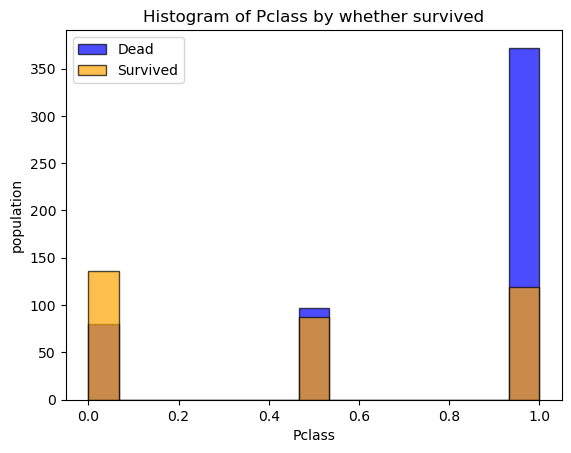

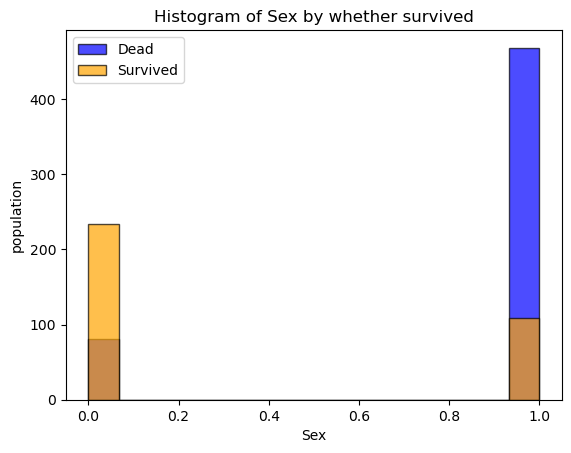

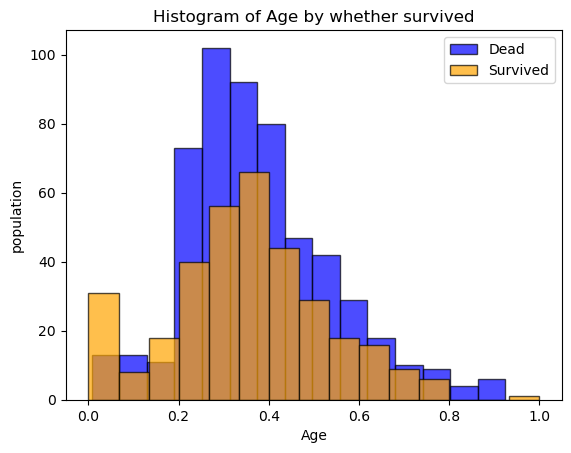

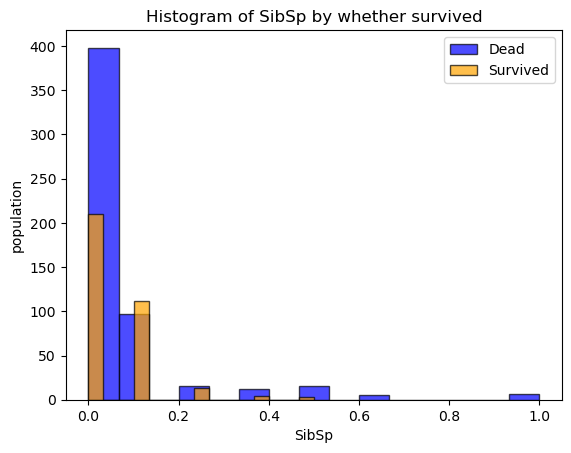

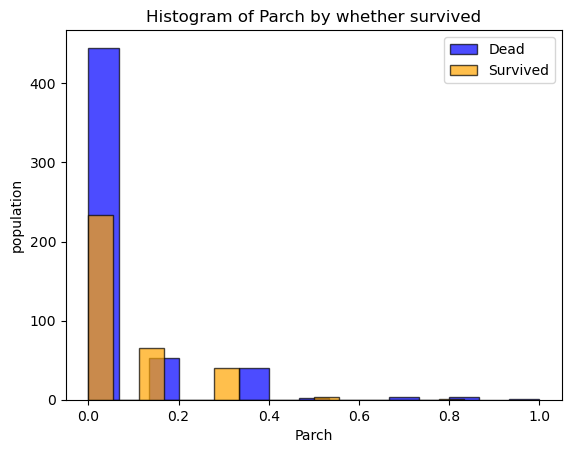

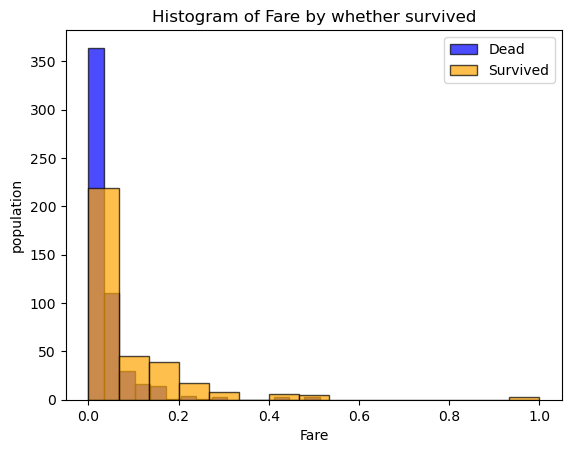

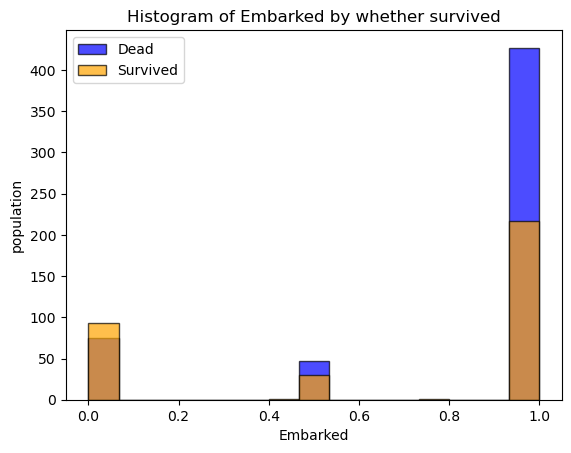

In [43]:
for name in colunm_names:
    plt.figure()
    data = pd.DataFrame({
        "name": train_DataFrame_filled[name],
        "target": train_DataFrame_filled["Survived"]
    })

    plt.hist(data[data['target'] == 0]["name"], bins=15, alpha=0.7, label='Dead', color='blue', edgecolor='black')
    plt.hist(data[data['target'] == 1]["name"], bins=15, alpha=0.7, label='Survived', color='orange', edgecolor='black')

    plt.title('Histogram of ' + name + ' by whether survived')
    plt.xlabel(name)
    plt.ylabel('population')
    plt.legend()
    plt.savefig("Picture/Titanic/" + name + ".png")
    plt.show()
   


In [44]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import learning_curve
import numpy as np
from joblib import dump

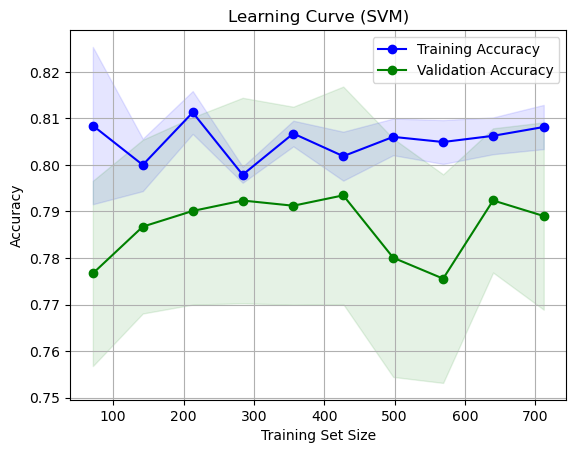

Start training...
Done!
SVM_model has been saved!
Training Dataset Accuracy: 0.81
Training Dataset Classification Report:
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85       549
         1.0       0.78      0.70      0.74       342

    accuracy                           0.81       891
   macro avg       0.80      0.79      0.79       891
weighted avg       0.81      0.81      0.80       891

Training Dataset Confusion Matrix:
[[480  69]
 [103 239]]


In [45]:
SVM_model = SVC(
    kernel='rbf', 
    gamma='scale', 
    C=1.0, 
    probability=True, 
    class_weight='balanced', 
    # class_weight={0: 1, 1: 4, 2: 0.5, 3: 0.8, 4:0.8, 5:0.7, 6:0.8},
    tol=1e-5, 
    max_iter=-1
)

# 使用 learning_curve 计算训练集和验证集的准确率
train_sizes, train_scores, test_scores = learning_curve(
    estimator=SVM_model,
    X=train_dataset,
    y=train_label,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 训练集大小比例
    cv=5,                                   # 5 折交叉验证
    scoring='accuracy',                     # 使用准确率作为评分指标
    n_jobs=-1                               # 并行计算
)

# 计算平均值和标准差
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 绘制学习曲线
plt.figure()
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

plt.title('Learning Curve (SVM)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.savefig("Picture/Titanic/SVM_Learning Curve.png")
plt.show()

print("Start training...")
SVM_model.fit(train_dataset, train_label)
print("Done!")

dump(SVM_model, "Model/Titanic_SVM_model.joblib")
print("SVM_model has been saved!")

label_pred = SVM_model.predict(train_dataset)
# 计算准确率
accuracy = accuracy_score(train_label, label_pred)
print(f"Training Dataset Accuracy: {accuracy:.2f}")

# 打印分类报告
print("Training Dataset Classification Report:")
print(classification_report(train_label, label_pred))

# 打印混淆矩阵
print("Training Dataset Confusion Matrix:")
print(confusion_matrix(train_label, label_pred))

In [46]:
label_pred = SVM_model.predict(test_dataset)

# 计算准确率
accuracy = accuracy_score(test_label, label_pred)
print(f"Accuracy: {accuracy:.2f}")

# 打印分类报告
print("Classification Report:")
print(classification_report(test_label, label_pred))

# 打印混淆矩阵
print("Confusion Matrix:")
print(confusion_matrix(test_label, label_pred))

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       266
           1       0.97      0.97      0.97       152

    accuracy                           0.98       418
   macro avg       0.98      0.98      0.98       418
weighted avg       0.98      0.98      0.98       418

Confusion Matrix:
[[262   4]
 [  5 147]]


# Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
RF_model = RandomForestClassifier(
    n_estimators=60, 
    criterion='entropy', 
    max_depth=7, 
    min_samples_split=3,
    class_weight="balanced",
    bootstrap=True,
    oob_score=True,
)

print("Start training...")
RF_model.fit(train_dataset, train_label)
print("Done!")

dump(RF_model, "Model/Titanic_RF_model.joblib")
print("RF_model has been saved!")

label_pred = RF_model.predict(train_dataset)
# 计算准确率
accuracy = accuracy_score(train_label, label_pred)
print(f"Training Dataset Accuracy: {accuracy:.2f}")

# 打印分类报告
print("Training Dataset Classification Report:")
print(classification_report(train_label, label_pred))

# 打印混淆矩阵
print("Training Dataset Confusion Matrix:")
print(confusion_matrix(train_label, label_pred))

Start training...
Done!
RF_model has been saved!
Training Dataset Accuracy: 0.89
Training Dataset Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91       549
         1.0       0.84      0.86      0.85       342

    accuracy                           0.89       891
   macro avg       0.88      0.88      0.88       891
weighted avg       0.89      0.89      0.89       891

Training Dataset Confusion Matrix:
[[494  55]
 [ 47 295]]


In [49]:
label_pred = RF_model.predict(test_dataset)

# 计算准确率
accuracy = accuracy_score(test_label, label_pred)
print(f"Accuracy: {accuracy:.2f}")

# 打印分类报告
print("Classification Report:")
print(classification_report(test_label, label_pred))

# 打印混淆矩阵
print("Confusion Matrix:")
print(confusion_matrix(test_label, label_pred))

Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       266
           1       0.83      0.93      0.88       152

    accuracy                           0.91       418
   macro avg       0.89      0.91      0.90       418
weighted avg       0.91      0.91      0.91       418

Confusion Matrix:
[[237  29]
 [ 10 142]]


# Multiple Layer Perceptron

In [50]:
from sklearn.neural_network import MLPClassifier

Start training...
Done!
MLP_model has been saved!


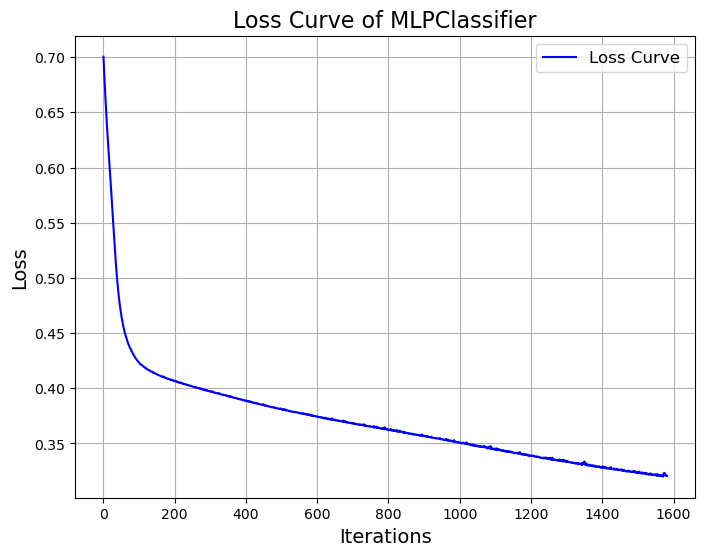

Training Dataset Accuracy: 0.86
Training Dataset Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89       549
         1.0       0.90      0.72      0.80       342

    accuracy                           0.86       891
   macro avg       0.87      0.83      0.85       891
weighted avg       0.86      0.86      0.86       891

Training Dataset Confusion Matrix:
[[521  28]
 [ 96 246]]


In [51]:
MLP_model = MLPClassifier(
    hidden_layer_sizes=(200, 50, 200),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    learning_rate_init=0.0001,
    max_iter=2000,
    tol=1e-8,
    verbose=False,
)

print("Start training...")
MLP_model.fit(train_dataset, train_label)
print("Done!")

dump(MLP_model, "Model/Titanic_MLP_model.joblib")
print("MLP_model has been saved!")

plt.figure(figsize=(8, 6))
plt.plot(MLP_model.loss_curve_, label='Loss Curve', color='blue')
plt.title('Loss Curve of MLPClassifier', fontsize=16)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.savefig("Picture/Titanic/MLP_LossCurve.png")
plt.show()

label_pred = MLP_model.predict(train_dataset)
# 计算准确率
accuracy = accuracy_score(train_label, label_pred)
print(f"Training Dataset Accuracy: {accuracy:.2f}")

# 打印分类报告
print("Training Dataset Classification Report:")
print(classification_report(train_label, label_pred))

# 打印混淆矩阵
print("Training Dataset Confusion Matrix:")
print(confusion_matrix(train_label, label_pred))

In [52]:
label_pred = MLP_model.predict(test_dataset)

# 计算准确率
accuracy = accuracy_score(test_label, label_pred)
print(f"Accuracy: {accuracy:.2f}")

# 打印分类报告
print("Classification Report:")
print(classification_report(test_label, label_pred))

# 打印混淆矩阵
print("Confusion Matrix:")
print(confusion_matrix(test_label, label_pred))

Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       266
           1       0.83      0.76      0.79       152

    accuracy                           0.85       418
   macro avg       0.85      0.83      0.84       418
weighted avg       0.85      0.85      0.85       418

Confusion Matrix:
[[242  24]
 [ 37 115]]


# [Other Good Solutions From Kaggle](https://www.kaggle.com/code/frtgnn/introduction-to-pytorch-a-very-gentle-start) 
- Thanks to @Firat Gonen

## 加载数据集

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

df_train = pd.read_csv('./Data/Titanic/train.csv')
df_test  = pd.read_csv('./Data/Titanic/test.csv')
df_sub   = pd.read_csv('./Data/Titanic/gender_submission.csv')

## 准备数据集

In [54]:
df_train.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)
df_test.drop( ['Name','Ticket','Cabin'],axis=1,inplace=True)

sex      = pd.get_dummies(df_train['Sex'],drop_first=True)
embark   = pd.get_dummies(df_train['Embarked'],drop_first=True)
df_train = pd.concat([df_train,sex,embark],axis=1)

df_train.drop(['Sex','Embarked'],axis=1,inplace=True)

sex     = pd.get_dummies(df_test['Sex'],drop_first=True)
embark  = pd.get_dummies(df_test['Embarked'],drop_first=True)
df_test = pd.concat([df_test,sex,embark],axis=1)

df_test.drop(['Sex','Embarked'],axis=1,inplace=True)

df_train.fillna(df_train.mean(),inplace=True)
df_test.fillna(df_test.mean(),inplace=True)

Scaler1 = StandardScaler()
Scaler2 = StandardScaler()

train_columns = df_train.columns
test_columns  = df_test.columns

df_train = pd.DataFrame(Scaler1.fit_transform(df_train))
df_test  = pd.DataFrame(Scaler2.fit_transform(df_test))

df_train.columns = train_columns
df_test.columns  = test_columns

features = df_train.iloc[:,2:].columns.tolist()
target   = df_train.loc[:, 'Survived'].name

X_train = df_train.iloc[:,2:].values
y_train = df_train.loc[:, 'Survived'].values

## PyTorch线性神经网路模型

In [55]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
# from tqdm import trange

In [56]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=8, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## 设置损失函数

In [57]:
criterion = nn.CrossEntropyLoss()

## 设置优化器

In [58]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

## 训练

In [59]:
batch_size = 64
n_epochs = 500
batch_no = len(X_train) // batch_size

train_loss = 0
train_loss_min = np.Inf
for epoch in range(n_epochs):
    for i in range(batch_no):
        start = i * batch_size
        end   = start + batch_size
        x_var = Variable(torch.FloatTensor(X_train[start:end]))
        y_var = Variable(torch.LongTensor(y_train[start:end])) 
        
        optimizer.zero_grad()
        output = model(x_var)
        loss   = criterion(output,y_var)
        loss.backward()
        optimizer.step()
        
        values, labels = torch.max(output, 1)
        num_right   = np.sum(labels.data.numpy() == y_train[start:end])
        train_loss += loss.item()*batch_size
    
    train_loss = train_loss / len(X_train)
    if train_loss <= train_loss_min:
        print("Validation loss decreased ({:6f} ===> {:6f}). Saving the model...".format(train_loss_min,train_loss))
        torch.save(model.state_dict(), "Model/Titanic_Linear_model.pt")
        train_loss_min = train_loss
    
    if epoch % 200 == 0:
        print('')
        print("Epoch: {} \tTrain Loss: {} \tTrain Accuracy: {}".format(epoch+1, train_loss,num_right / len(y_train[start:end]) ))
print('Training Ended! ')

Validation loss decreased (   inf ===> 0.624974). Saving the model...

Epoch: 1 	Train Loss: 0.6249741319855455 	Train Accuracy: 0.0
Validation loss decreased (0.624974 ===> 0.583681). Saving the model...
Validation loss decreased (0.583681 ===> 0.553491). Saving the model...
Validation loss decreased (0.553491 ===> 0.530732). Saving the model...
Validation loss decreased (0.530732 ===> 0.510873). Saving the model...
Validation loss decreased (0.510873 ===> 0.491849). Saving the model...
Validation loss decreased (0.491849 ===> 0.478378). Saving the model...
Validation loss decreased (0.478378 ===> 0.469930). Saving the model...
Validation loss decreased (0.469930 ===> 0.456828). Saving the model...
Validation loss decreased (0.456828 ===> 0.444583). Saving the model...
Validation loss decreased (0.444583 ===> 0.443973). Saving the model...
Validation loss decreased (0.443973 ===> 0.441956). Saving the model...
Validation loss decreased (0.441956 ===> 0.435154). Saving the model...
Val

## 预测

In [60]:
X_test     = df_test.iloc[:,1:].values
X_test_var = Variable(torch.FloatTensor(X_test), requires_grad=False) 
with torch.no_grad():
    test_result = model(X_test_var)
values, labels = torch.max(test_result, 1)
survived = labels.data.numpy()

## 结果保存

In [61]:
submission = pd.DataFrame({'PassengerId': df_sub['PassengerId'], 'Survived': survived})
submission.to_csv('Answer/Titanic_submission.csv', index=False)

## 正确率

In [62]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [63]:
y_pred_df = pd.read_csv('Answer/Titanic_submission.csv', names=["PassengerId", "Survived"], skiprows=1)
y_test_df = pd.read_csv('Data/Titanic/gender_submission.csv', names=["PassengerId", "Survived"], skiprows=1)

y_pred = [y_pred_df["Survived"][i] for i in range(len(y_pred_df))]
y_test = [y_test_df["Survived"][i] for i in range(len(y_test_df))]

In [64]:
# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# 打印分类报告
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 打印混淆矩阵
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       266
           1       0.86      0.80      0.83       152

    accuracy                           0.88       418
   macro avg       0.87      0.86      0.87       418
weighted avg       0.88      0.88      0.88       418

Confusion Matrix:
[[246  20]
 [ 31 121]]
